<a href="https://colab.research.google.com/github/Tamircohen28/baswana-sen-spanner-experiments/blob/main/notebooks/02_experiments_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment Results Analysis

This notebook loads and analyzes the results from spanner experiments.


In [ ]:
# @title
import sys
from pathlib import Path

# Add src to path
sys.path.insert(0, str(Path().absolute().parent))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.evaluation.metrics import aggregate_results
from IPython.display import display, HTML

# Set professional aesthetic
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
# Define a color palette that distinguishes 'Safe' (blue/green) from 'Warning' (red/orange)
palette = sns.color_palette("viridis", as_cmap=False)
WARNING_COLOR = "#D62728"  # Red for violations
SUCCESS_COLOR = "#2CA02C"  # Green for compliance
THEORETICAL_COLOR = "#000000" # Black for theoretical lines

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


## Load experiment results


In [ ]:
# @title
# Find the most recent results file
data_dir = Path('../data/processed')
results_files = list(data_dir.glob('experiments-results-*.csv'))

if not results_files:
    raise FileNotFoundError(
        f"No experiment results files found in {data_dir.absolute()}\n"
        "Please run experiments first using: python scripts/run_all_experiments.py"
    )

# Sort by modification time (most recent first)
results_files.sort(key=lambda p: p.stat().st_mtime, reverse=True)
results_path = results_files[0]

# Load data
df = pd.read_csv(results_path)
print(f"✓ Loaded {len(df)} experiment results from {results_path.name}")


✓ Loaded 540 experiment results from experiments-results-19-12-2025-14-12-37.csv


## Plot 1: Experiment Overview

This section provides a high-level overview of the experimental parameters and data distribution.


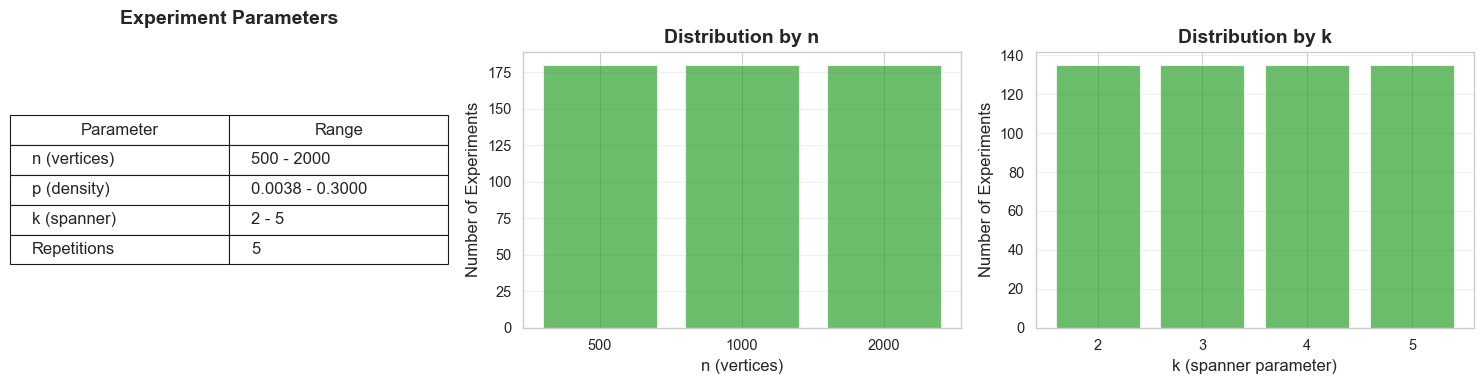


Total experiments: 540


In [ ]:
# @title
if not df.empty:
    # Create a summary visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Parameter ranges
    ax = axes[0]
    summary_data = {
        'Parameter': ['n (vertices)', 'p (density)', 'k (spanner)', 'Repetitions'],
        'Range': [
            f"{df['n'].min()} - {df['n'].max()}",
            f"{df['p'].min():.4f} - {df['p'].max():.4f}",
            f"{df['k'].min()} - {df['k'].max()}",
            f"{df['rep'].max() + 1}"
        ]
    }
    summary_df = pd.DataFrame(summary_data)
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=summary_df.values, colLabels=summary_df.columns,
                    cellLoc='left', loc='center', colWidths=[0.5, 0.5])
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 2)
    ax.set_title('Experiment Parameters', fontsize=14, fontweight='bold', pad=20)

    # Distribution of n values
    ax = axes[1]
    n_counts = df['n'].value_counts().sort_index()
    ax.bar(n_counts.index.astype(str), n_counts.values, color=SUCCESS_COLOR, alpha=0.7)
    ax.set_xlabel('n (vertices)', fontsize=12)
    ax.set_ylabel('Number of Experiments', fontsize=12)
    ax.set_title('Distribution by n', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

    # Distribution of k values
    ax = axes[2]
    k_counts = df['k'].value_counts().sort_index()
    ax.bar(k_counts.index.astype(str), k_counts.values, color=SUCCESS_COLOR, alpha=0.7)
    ax.set_xlabel('k (spanner parameter)', fontsize=12)
    ax.set_ylabel('Number of Experiments', fontsize=12)
    ax.set_title('Distribution by k', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    print(f"\nTotal experiments: {len(df)}")


## Plot 2: Visual Data Distribution

**Purpose:** Visualize the distribution of spanner size **ratios** (normalized by theoretical bound) to check for stability and outliers across repetitions. Since Baswana-Sen is a randomized algorithm, variance is expected, but we need to identify any wild outliers.

**Why Ratio Instead of Absolute Size?**
- **Normalized Comparison:** Using `spanner_size_ratio` (empirical / theoretical) allows fair comparison across different graph sizes (n) and densities (p)
- **True Stability:** Narrow distributions indicate the algorithm is consistent across repetitions
- **Accuracy Indicator:** If values cluster near 1.0 (or below), the algorithm is efficient
- **Real Outliers:** Extreme values represent *actual* problematic runs, not just larger graphs


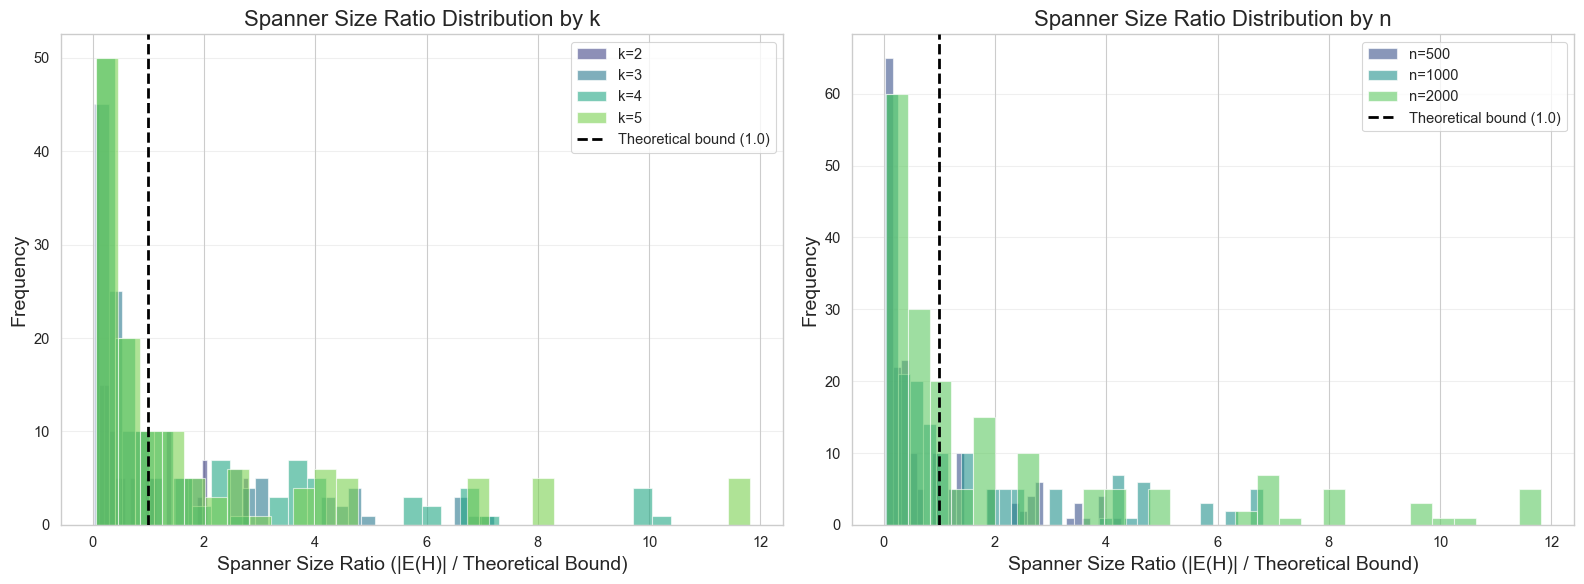

In [ ]:
# @title
if not df.empty:
    # Histograms for spanner size RATIO distribution by k and n
    # Using ratio normalizes the data to compare across different graph sizes and densities
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    df_plot = df[df['spanner_size_ratio'].notna()].copy()

    # Get color palette for different k values
    k_colors = sns.color_palette("viridis", n_colors=len(df_plot['k'].unique()))

    # Histogram by k
    ax = axes[0]
    for idx, k in enumerate(sorted(df_plot['k'].unique())):
        k_data = df_plot[df_plot['k'] == k]['spanner_size_ratio']
        ax.hist(k_data, alpha=0.6, label=f'k={k}', bins=30, color=k_colors[idx])
    ax.axvline(x=1.0, color=THEORETICAL_COLOR, linestyle='--', linewidth=2,
              label='Theoretical bound (1.0)', zorder=10)
    ax.set_xlabel('Spanner Size Ratio (|E(H)| / Theoretical Bound)', fontsize=14)
    ax.set_ylabel('Frequency', fontsize=14)
    ax.set_title('Spanner Size Ratio Distribution by k', fontsize=16)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    # Get color palette for different n values
    n_colors = sns.color_palette("viridis", n_colors=len(df_plot['n'].unique()))

    # Histogram by n
    ax = axes[1]
    for idx, n in enumerate(sorted(df_plot['n'].unique())):
        n_data = df_plot[df_plot['n'] == n]['spanner_size_ratio']
        ax.hist(n_data, alpha=0.6, label=f'n={n}', bins=30, color=n_colors[idx])
    ax.axvline(x=1.0, color=THEORETICAL_COLOR, linestyle='--', linewidth=2,
              label='Theoretical bound (1.0)', zorder=10)
    ax.set_xlabel('Spanner Size Ratio (|E(H)| / Theoretical Bound)', fontsize=14)
    ax.set_ylabel('Frequency', fontsize=14)
    ax.set_title('Spanner Size Ratio Distribution by n', fontsize=16)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()


## Plot 3: Summary Statistics by Parameter

Visual summary of key metrics grouped by experimental parameters.


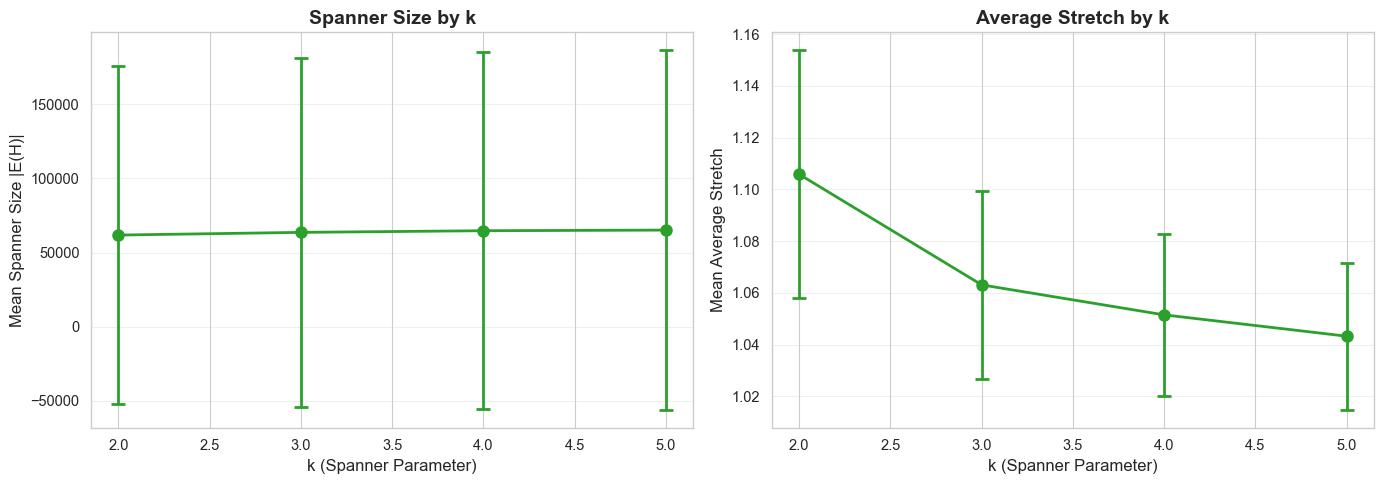

In [ ]:
# @title
if not df.empty:
    # Visual summary by k
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Spanner size by k - line plot with error bars
    ax = axes[0]
    summary_k = df.groupby('k')['spanner_size'].agg(['mean', 'std']).reset_index()
    ax.errorbar(summary_k['k'], summary_k['mean'], yerr=summary_k['std'],
               marker='o', linestyle='-', linewidth=2, markersize=8,
               color=SUCCESS_COLOR, capsize=5, capthick=2)
    ax.set_xlabel('k (Spanner Parameter)', fontsize=12)
    ax.set_ylabel('Mean Spanner Size |E(H)|', fontsize=12)
    ax.set_title('Spanner Size by k', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

    # Stretch by k (filter out inf values) - line plot with error bars
    ax = axes[1]
    df_stretch_clean = df[df['avg_stretch_edges'] != np.inf].copy()
    if not df_stretch_clean.empty:
        summary_stretch = df_stretch_clean.groupby('k')['avg_stretch_edges'].agg(['mean', 'std']).reset_index()
        ax.errorbar(summary_stretch['k'], summary_stretch['mean'],
                   yerr=summary_stretch['std'], marker='o', linestyle='-',
                   linewidth=2, markersize=8, color=SUCCESS_COLOR, capsize=5, capthick=2)
        ax.set_xlabel('k (Spanner Parameter)', fontsize=12)
        ax.set_ylabel('Mean Average Stretch', fontsize=12)
        ax.set_title('Average Stretch by k', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()


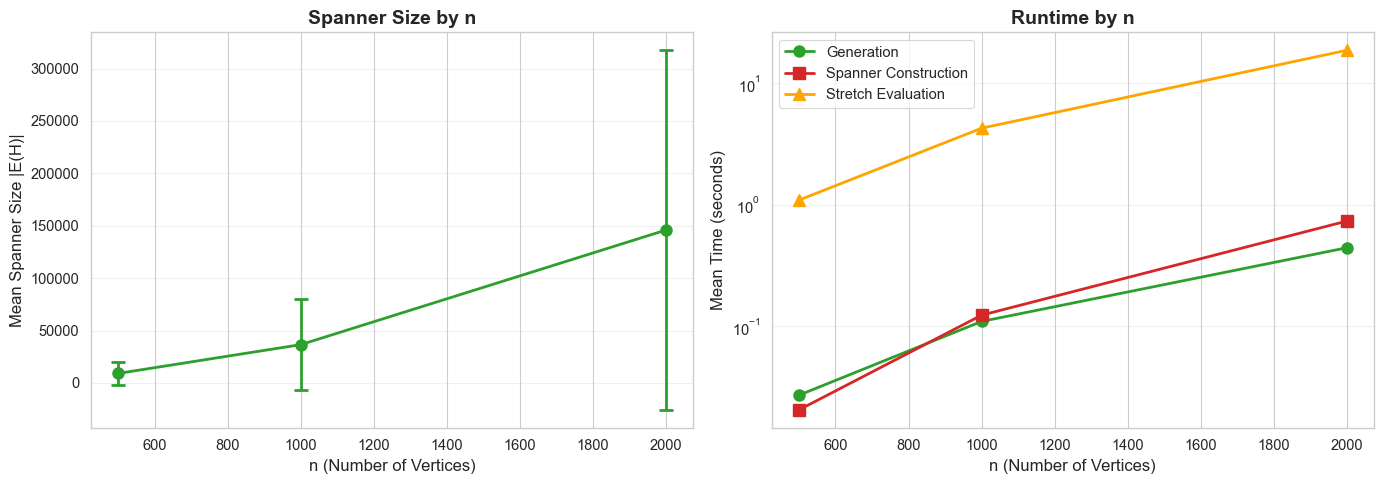

In [ ]:
# @title
if not df.empty:
    # Visual summary by n
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Spanner size by n - line plot with error bars
    ax = axes[0]
    summary_n = df.groupby('n')['spanner_size'].agg(['mean', 'std']).reset_index()
    ax.errorbar(summary_n['n'], summary_n['mean'], yerr=summary_n['std'],
               marker='o', linestyle='-', linewidth=2, markersize=8,
               color=SUCCESS_COLOR, capsize=5, capthick=2)
    ax.set_xlabel('n (Number of Vertices)', fontsize=12)
    ax.set_ylabel('Mean Spanner Size |E(H)|', fontsize=12)
    ax.set_title('Spanner Size by n', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

    # Runtime by n - line plots for each component
    ax = axes[1]
    summary_time = df.groupby('n')[['time_gen', 'time_spanner', 'time_stretch']].mean().reset_index()
    ax.plot(summary_time['n'], summary_time['time_gen'], marker='o', linestyle='-',
           linewidth=2, markersize=8, label='Generation', color=SUCCESS_COLOR)
    ax.plot(summary_time['n'], summary_time['time_spanner'], marker='s', linestyle='-',
           linewidth=2, markersize=8, label='Spanner Construction', color=WARNING_COLOR)
    ax.plot(summary_time['n'], summary_time['time_stretch'], marker='^', linestyle='-',
           linewidth=2, markersize=8, label='Stretch Evaluation', color='#FFA500')
    ax.set_xlabel('n (Number of Vertices)', fontsize=12)
    ax.set_ylabel('Mean Time (seconds)', fontsize=12)
    ax.set_title('Runtime by n', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_yscale('log')

    plt.tight_layout()
    plt.show()


## Plot 4: ⚠️ Theoretical Compliance Dashboard

**Critical Analysis:** This section flags any results that **contradict the theoretical guarantees** of the Baswana-Sen algorithm.

### Theoretical Guarantees:
- **Stretch Bound:** For a (2k-1)-spanner, the maximum stretch must be ≤ (2k-1)
- **Size Expectation:** Spanner size should be approximately O(k·n^(1+1/k))

**⚠️ Warning:** If any row is highlighted in **orange/red**, it indicates a **violation** of the theoretical bounds, which may indicate a bug in the algorithm implementation.


In [ ]:
# @title
if not df.empty:
    def highlight_violations(row):
        """Highlight violations using colorblind-safe colors and bold text.
        Returns a Series with style strings for each column in the row."""
        style = ''

        # CRITICAL VIOLATION: Stretch exceeds theoretical bound (2k-1)
        # This contradicts the Baswana-Sen theorem - indicates potential bug
        if pd.notna(row['actual_stretch']):
            if row['actual_stretch'] > row['expected_stretch']:
                style = f'background-color: {WARNING_COLOR}; color: white; font-weight: bold;'

        # Return Series with same style for all columns
        return pd.Series([style] * len(row), index=row.index)

    # Create a focused compliance dataframe with essential columns only
    compliance_df = df[['n', 'p', 'k', 'rep', 'max_stretch_edges']].copy()

    # Add expected and actual values for easy comparison
    compliance_df['expected_stretch'] = 2 * compliance_df['k'] - 1
    compliance_df['actual_stretch'] = compliance_df['max_stretch_edges'].replace([np.inf, -np.inf], np.nan)

    # Reorder columns for clarity: n, p, k, rep, expected, actual
    compliance_df = compliance_df[['n', 'p', 'k', 'rep', 'expected_stretch', 'actual_stretch']]

    # Display styled dataframe with header
    display(HTML("<h3>[WARNING] Compliance Report: Theoretical Violations</h3>"))
    display(HTML("<p><strong>Red rows</strong> = Stretch violation (actual > expected, contradicts theorem). "
                 "<strong>Orange rows</strong> = Size anomaly (suspicious but possible).</p>"))

    # Show only violations first
    violations = compliance_df[
        (compliance_df['actual_stretch'].notna()) &
        (compliance_df['actual_stretch'] > compliance_df['expected_stretch'])
    ]
    if len(violations) > 0:
        display(HTML(f"<h4>[WARNING] Found {len(violations)} stretch violations:</h4>"))
        styled_violations = violations.style.apply(highlight_violations, axis=1)
        display(styled_violations)

    # Show sample of all data (first 50 rows)
    display(HTML("<h4>Sample of all experiments (first 50 rows):</h4>"))
    styled = compliance_df.head(50).style.apply(highlight_violations, axis=1)
    display(styled)

    # Summary statistics
    violation_count = len(violations)
    print(f"\n{'='*80}")
    print(f"Violations Summary:")
    print(f"  [WARNING] Stretch violations (actual > expected): {violation_count} out of {len(compliance_df)}")
    print(f"\n{'='*80}")
    print(f"Note: Red rows contradict the Baswana-Sen theorem and may indicate a bug.")


,n,p,k,rep,expected_stretch,actual_stretch
8,500,0.003800,3,3,5,11.000000
11,500,0.003800,4,1,7,19.000000
45,500,0.012429,3,0,5,6.000000
49,500,0.012429,3,4,5,6.000000
83,500,0.031623,2,3,3,5.000000
84,500,0.031623,2,4,3,5.000000
100,500,0.044721,2,0,3,4.000000
103,500,0.044721,2,3,3,4.000000
190,1000,0.003800,4,0,7,8.000000
194,1000,0.003800,4,4,7,8.000000


,n,p,k,rep,expected_stretch,actual_stretch
0,500,0.003800,2,0,3,nan
1,500,0.003800,2,1,3,nan
2,500,0.003800,2,2,3,nan
3,500,0.003800,2,3,3,nan
4,500,0.003800,2,4,3,nan
5,500,0.003800,3,0,5,nan
6,500,0.003800,3,1,5,nan
7,500,0.003800,3,2,5,nan
8,500,0.003800,3,3,5,11.000000
9,500,0.003800,3,4,5,nan



Violations Summary:
  [WARNING] Stretch violations (actual > expected): 22 out of 540

Note: Red rows contradict the Baswana-Sen theorem and may indicate a bug.
